<a href="https://colab.research.google.com/github/anupam3693/eip2/blob/master/Anupam_Kumar_EIP2_Batch2_Assignment_DNST_CIFAR10_AUG_exp1_run2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://keras.io/
# !pip install -q keras 
# import keras 
# print(keras.__version__)

In [0]:
import keras
import time
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback

Using TensorFlow backend.


In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Hyperparameters
# batch_size = 32
# num_classes =  10
# epochs = 50
# l = 40
# num_filter = 10
# compression = 0.5
# dropout_rate = 0

batch_size = 64
num_classes =  10
epochs = 100
l = 20
num_filter = 28
compression = 0.9
dropout_rate = 0.2


In [0]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoding 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
 
# #z-score
# mean = np.mean(x_train,axis=(0,1,2,3))
# std = np.std(x_train,axis=(0,1,2,3))
# x_train = (x_train-mean)/(std+1e-7)
# x_test = (x_test-mean)/(std+1e-7)

In [0]:
# Dense Block
def add_denseblock(input, num_filter, dropout_rate):
    global compression
    temp = input
    for _ in range(l):
        Dense_Conv2D_1_1 = Conv2D(num_filter, (1,1), use_bias=False ,padding='same')(temp)
        BatchNorm = BatchNormalization()(Dense_Conv2D_1_1)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter, dropout_rate):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [0]:
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

# Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate=0.2)
output = output_layer(Third_Transition)


In [0]:
model = Model(inputs=[input], outputs=[output])
model.load_weights('DNST_model_weights_s1_v1.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 28)   756         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 28)   784         conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 28)   112         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation

In [0]:
# ak - block 3 learning rate 
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 20:
        lrate = 0.0001
    elif epoch > 50:
        lrate = 0.00001 
    return lrate

# checkpointer
# checkpointer = ModelCheckpoint(filepath='s1_v1_weights.{epoch:02d}-{val_loss:.2f}--{val_acc:.2f}.hdf5',monitor='val_acc', mode=max, verbose=1, save_best_only=True, save_weights_only=True)

lrate = LearningRateScheduler(lr_schedule)

#lr reducer
# lr_reducer  = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                                    cooldown=0, patience=10, min_lr=0.1e-4)
# early stopper

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, verbose=1,mode='min')

# gamma_regularizer=12(decay),beta_regularizer=12(decay

In [0]:
# determine Loss function and Optimizer
# decay=10e-4,momentum=0.9
sgd = SGD(momentum=0.9,decay=10e-4)

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
# ak - block 4 - image aug

# we can compare the performance with or without data augmentation
data_augmentation = False
callbacks_list=[lrate,earlystopper]

start = time.time()
if not data_augmentation:
    print('Not using data augmentation.')
    model_info = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        shuffle=True,
        callbacks=callbacks_list
        )
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=15,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.1,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    
    model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=2*(x_train.shape[0]//batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list
                       )

end = time.time()


Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 100s 2ms/step - loss: 0.0690 - acc: 0.9763 - val_loss: 0.2389 - val_acc: 0.9325
Epoch 2/100
50000/50000 [==============================] - 85s 2ms/step - loss: 0.0675 - acc: 0.9766 - val_loss: 0.2367 - val_acc: 0.9327
Epoch 3/100
50000/50000 [==============================] - 85s 2ms/step - loss: 0.0637 - acc: 0.9783 - val_loss: 0.2364 - val_acc: 0.9338
Epoch 4/100
50000/50000 [==============================] - 85s 2ms/step - loss: 0.0651 - acc: 0.9782 - val_loss: 0.2353 - val_acc: 0.9342
Epoch 5/100
50000/50000 [==============================] - 85s 2ms/step - loss: 0.0658 - acc: 0.9781 - val_loss: 0.2337 - val_acc: 0.9338
Epoch 6/100
50000/50000 [==============================] - 84s 2ms/step - loss: 0.0625 - acc: 0.9785 - val_loss: 0.2341 - val_acc: 0.9344
Epoch 7/100
50000/50000 [==============================] - 85s 2ms/step - loss: 0.0635 - acc

Model took 0.26 hours to train


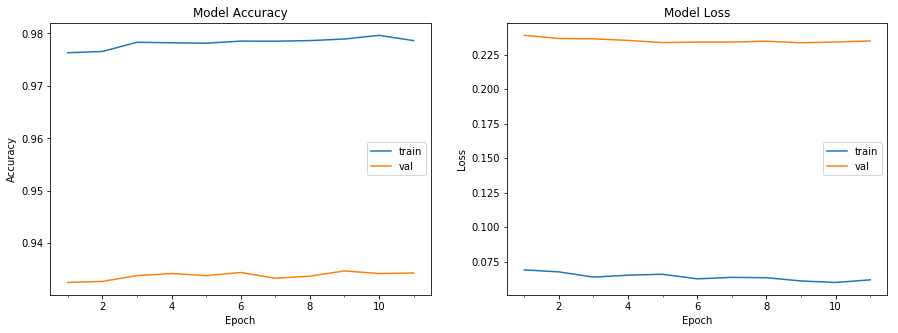

In [0]:
print ("Model took %0.2f hours to train"%((end - start)/3600))

plot_model_history(model_info)

In [0]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 4s 436us/step
Test loss: 0.23487854334264993
Test accuracy: 0.9343


In [0]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_weights_s1_v2.h5")
print("Saved model to disk")

Saved model to disk
